In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun  3 21:05:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import required dependencies
import pandas as pd
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from PIL import Image
from PIL.ImageStat import Stat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib
import cv2

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data setup

In [4]:
covidImages = "https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip?raw=true"
nonCovidImages = "https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_NonCOVID.zip?raw=true"

# create folders
if not os.path.exists('/content/ct/COVID'): 
    print("Creating covid folder") 
    os.makedirs('/content/ct/COVID')

tempPath = "/root/.keras/datasets/CT_COVID.zip"
if os.path.exists(tempPath):
  print(f'Path {tempPath} exists, so moving files')
  !mv /root/.keras/datasets/CT_COVID/* /content/ct/COVID/ 
else:  
  print('download and unzip the files')
  tf.keras.utils.get_file("CT_COVID.zip", covidImages, extract=True)
  !mv /root/.keras/datasets/CT_COVID/* /content/ct/COVID/

Creating covid folder
download and unzip the files
47931392/47929914 [==============================] - 2s 0us/step


In [5]:
# create folders
if not os.path.exists('/content/ct/NonCOVID'): 
    print("Creating non covid folder") 
    os.makedirs('/content/ct/NonCOVID')

tempPath = "/root/.keras/datasets/CT_NonCOVID.zip"
if os.path.exists(tempPath):
  print(f'Path {tempPath} exists, so moving files')
  !mv /root/.keras/datasets/CT_NonCOVID/* /content/ct/NonCOVID/ 
else:  
  print('download and unzip the files')
  tf.keras.utils.get_file("CT_NonCOVID.zip", nonCovidImages, extract=True)
  !mv /root/.keras/datasets/CT_NonCOVID/* /content/ct/NonCOVID/

Creating non covid folder
download and unzip the files
42090496/42084013 [==============================] - 1s 0us/step


In [6]:
import glob
#!ls /root/.keras/datasets -laR
covid_dir = os.path.join('/content','ct','COVID')
non_covid_dir =os.path.join('/content','ct','NonCOVID')
covidCount = len(  os.listdir(covid_dir) )
nonCovidCount = len( os.listdir(non_covid_dir))
print(f'{covidCount} covid images')
print(f'{nonCovidCount} non covid images')

349 covid images
397 non covid images


## Image preview

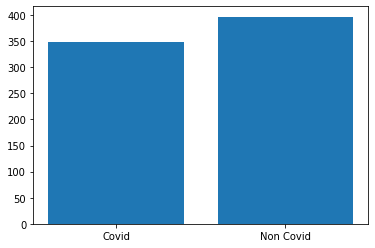

In [7]:
# Showing distribution of images
x = np.array([0,1])
plt.bar(x, height=[covidCount, nonCovidCount] )
plt.xticks(x, ['Covid', 'Non Covid'])
plt.show()

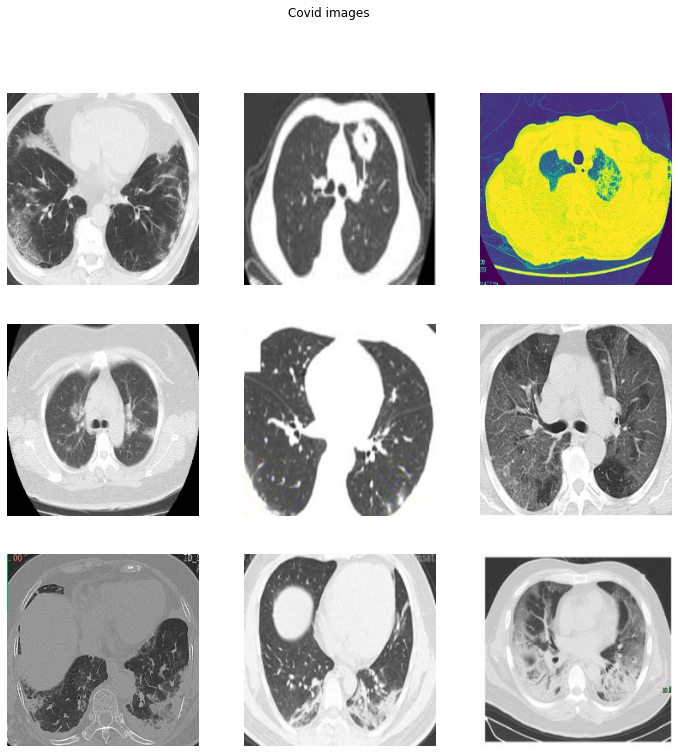

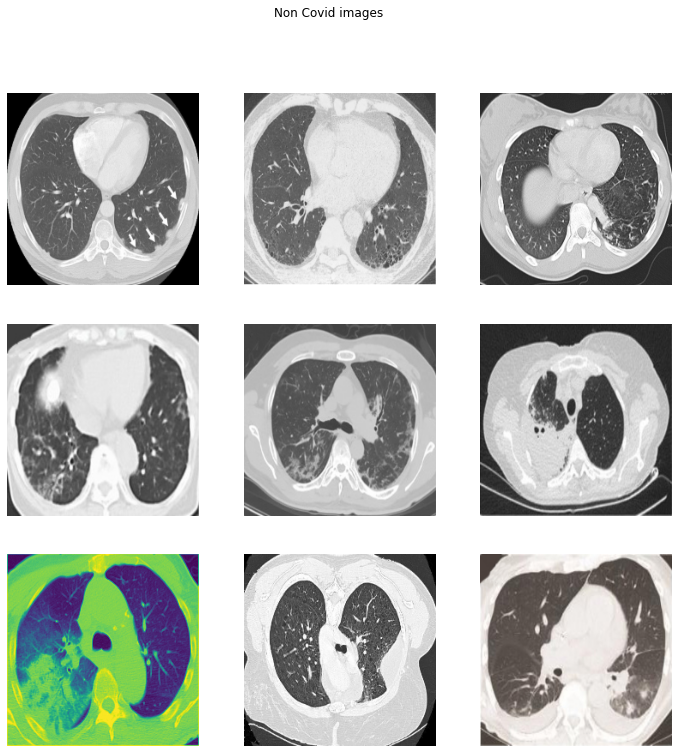

In [8]:
import random
batch_size = 32
img_height = 224
img_width = 224
size = (224,224)

nrows = 3
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

preview_covid = os.listdir(covid_dir)
preview_non_covid = os.listdir(non_covid_dir)

randIndex = random.randint(10, covidCount)
next_covid = [os.path.join(covid_dir, fname) 
              for fname in preview_covid[randIndex-9:randIndex]                 
             ]
randIndex = random.randint(10, nonCovidCount)
next_non_covid = [os.path.join(non_covid_dir, fname) 
              for fname in preview_non_covid[randIndex-9:randIndex]   
             ]
fig.suptitle('Covid images')
for i, img_path in enumerate(next_covid):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path,0)
  img = cv2.resize(img, size)
  plt.imshow(img)  
plt.show()     

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

fig.suptitle('Non Covid images')
for i, img_path in enumerate(next_non_covid):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path,0)
  img = cv2.resize(img, size)
  plt.imshow(img)  


plt.show()



### Image stats

[0]: Min/Max [(36, 255), (36, 255), (36, 255)] Mean [162.54418254224518, 162.54418254224518, 162.54418254224518], Variance [5153.049048871638, 5153.049048871638, 5153.049048871638], StdDev [71.78474105874895, 71.78474105874895, 71.78474105874895]
[1]: Min/Max [(0, 255), (0, 255), (0, 255), (255, 255)] Mean [140.52364740522634, 140.52364740522634, 140.52364740522634, 255.0], Variance [6580.177670465299, 6580.177670465299, 6580.177670465299, 0.0], StdDev [81.11829430199639, 81.11829430199639, 81.11829430199639, 0.0]
[2]: Min/Max [(0, 255)] Mean [160.4136124979037], Variance [10655.385267181293], StdDev [103.22492560995767]
[3]: Min/Max [(0, 255), (0, 255), (0, 255), (255, 255)] Mean [171.86136598908337, 171.86136598908337, 171.86136598908337, 255.0], Variance [5301.085711911598, 5301.085711911598, 5301.085711911598, 0.0], StdDev [72.80855521098876, 72.80855521098876, 72.80855521098876, 0.0]
[4]: Min/Max [(21, 255), (21, 255), (21, 255), (255, 255)] Mean [165.46448438856555, 165.414643557

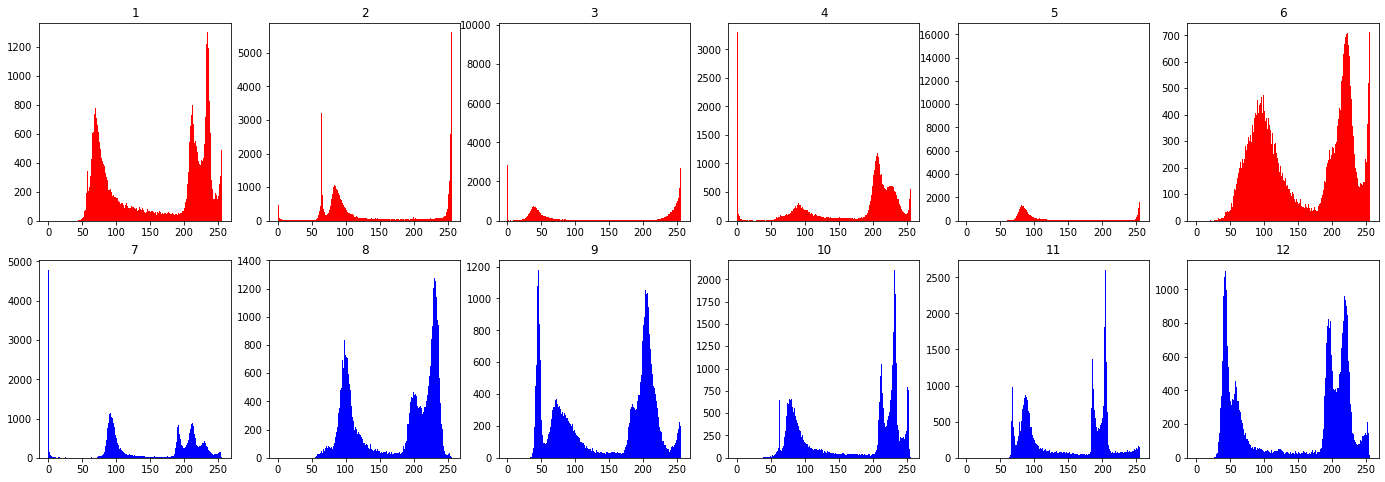

In [9]:



nrows = 2
ncols = 6

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
plt.title('Image distribution')
for i, img_path in enumerate(next_covid):
  if i > 5:
    break
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.set_label('Covid')
  sp.set_title(i + 1)
  img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, size)
  hist = cv2.calcHist([img],[0],None,[256],[0,256])
  plt.hist(img.ravel(),256,[0,256], color="red", label="Covid")
  
  img = Image.open(img_path)
  st = Stat(img)
  print(f'[{i}]: Min/Max {st.extrema} Mean {st.mean}, Variance {st.var}, StdDev {st.stddev}')  
  
print('')  

for i, img_path in enumerate(next_non_covid):
  if i > 5:
    break
  sp = plt.subplot(nrows, ncols, i + 7)
  sp.set_label('Covid')  
  sp.set_title(i + 7)
  img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, size)
  hist = cv2.calcHist([img],[0],None,[256],[0,256])
  plt.hist(img.ravel(),256,[0,256], color="blue", label="Non Covid")
  img = Image.open(img_path)
  st = Stat(img)
  print(f'[{i}]: Min/Max {st.extrema} Mean {st.mean}, Variance {st.var}, StdDev {st.stddev}')  


plt.show()

## Dicom image processing

In [10]:
# install utility for converting to dicom
!pip install simpleitk  > /dev/null 2>&1

In [11]:
def generateDicom(folderEnumerator, pathToTarget):
    for i, img_path in enumerate(folderEnumerator):
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, size)
        img = sitk.GetImageFromArray(img)
        sitk.WriteImage(img, os.path.join(pathToTarget + str(i) + '.dcm'))

In [12]:
import SimpleITK as sitk
import shutil

if not os.path.exists('/content/dicom/covid'): 
    print("Creating covid dicom folder") 
    os.makedirs('/content/dicom/covid')
else:
  shutil.rmtree('/content/dicom/covid')  
  print("Creating covid dicom folder") 
  os.makedirs('/content/dicom/covid')

if not os.path.exists('/content/dicom/non_covid'): 
    print("Creating non covid dicom folder") 
    os.makedirs('/content/dicom/non_covid')
else:
  shutil.rmtree('/content/dicom/non_covid')  
  print("Creating non covid dicom folder") 
  os.makedirs('/content/dicom/non_covid')

next_covid = [os.path.join(covid_dir, fname) 
              for fname in preview_covid                 
             ]
next_non_covid = [os.path.join(non_covid_dir, fname) 
              for fname in preview_non_covid   
             ]


Creating covid dicom folder
Creating non covid dicom folder


In [13]:

#Convert to dicom
generateDicom(next_covid, '/content/dicom/covid/c_')


#Convert to dicom
generateDicom(next_non_covid, '/content/dicom/non_covid/c_')

## Generate output csv files

In [14]:
# import to dataframes

next_covid_dicom = [os.path.join('/content/dicom/covid', fname) 
              for fname in os.listdir('/content/dicom/covid')                 
             ]
next_non_covid_dicom = [os.path.join('/content/dicom/non_covid', fname) 
              for fname in os.listdir('/content/dicom/non_covid')   
             ]


covidData = { 'paths': np.array(next_covid_dicom), 'label': 'covid' }
nonCovidData = { 'paths': np.array(next_non_covid_dicom), 'label': 'non-covid'}

frame = pd.DataFrame(covidData)
frame = frame.append(pd.DataFrame(nonCovidData), ignore_index=True)

frame


,paths,label
0,/content/dicom/covid/c_66.dcm,covid
1,/content/dicom/covid/c_281.dcm,covid
2,/content/dicom/covid/c_151.dcm,covid
3,/content/dicom/covid/c_190.dcm,covid
4,/content/dicom/covid/c_186.dcm,covid
...,...,...
741,/content/dicom/non_covid/c_2.dcm,non-covid
742,/content/dicom/non_covid/c_268.dcm,non-covid
743,/content/dicom/non_covid/c_324.dcm,non-covid
744,/content/dicom/non_covid/c_127.dcm,non-covid


In [15]:
# output to csv
frame.to_csv('/content/ctscans.csv')

In [16]:
# Load the csv back in to a dataframe

data = pd.read_csv('/content/ctscans.csv')
# convert label from string to int
mapping = {'non-covid': '0', 'covid': '1'}
data = data.replace({'label': mapping})
data.head()

,Unnamed: 0,paths,label
0,0,/content/dicom/covid/c_66.dcm,1
1,1,/content/dicom/covid/c_281.dcm,1
2,2,/content/dicom/covid/c_151.dcm,1
3,3,/content/dicom/covid/c_190.dcm,1
4,4,/content/dicom/covid/c_186.dcm,1


# VGG16

In [17]:
# Load the csv back in to a dataframe

data = pd.read_csv('/content/ctscans.csv')
# convert label from string to int
mapping = {'non-covid': '0', 'covid': '1'}
data = data.replace({'label': mapping})
data.head()

,Unnamed: 0,paths,label
0,0,/content/dicom/covid/c_66.dcm,1
1,1,/content/dicom/covid/c_281.dcm,1
2,2,/content/dicom/covid/c_151.dcm,1
3,3,/content/dicom/covid/c_190.dcm,1
4,4,/content/dicom/covid/c_186.dcm,1


In [18]:
from sklearn.model_selection import train_test_split
# split data 20% test

train_set, test_set = train_test_split(data, test_size=0.2)

In [19]:
# Data augmentation
# use image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., 
                                                                rotation_range = 40, width_shift_range = 0.2, 
                                                                height_shift_range = 0.2, shear_range = 0.2, 
                                                                zoom_range = 0.2, horizontal_flip = True,  validation_split = 0.2)

validation_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., 
                                                              validation_split = 0.2)

test_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

In [20]:
# install pydicom
!pip install pydicom

     |████████████████████████████████| 1.9MB 2.9MB/s 


In [21]:
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
import pydicom

#DICOM image reader
# https://gist.github.com/ReemRashwan/8c92086d3104d01978a16e05ca93a165
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(224, 224), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)

        return image_array

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 224
img_width = 224
class_mode = 'binary'
colour_mode = 'rgb'
seed = 1234
num_epochs = 30

train_consts = {
    'seed': seed,
    'batch_size': batch_size,
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width),  
    'subset': 'training'
}

valid_consts = {
   'seed': seed,
    'batch_size': batch_size,
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width),  
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width), 
    'shuffle': False
}

train_generator = DCMDataFrameIterator(dataframe=train_set,
                             x_col='paths',
                             y_col='label',                      
                             image_data_generator=train_datagen,
                             **train_consts)

validation_generator = DCMDataFrameIterator(dataframe=train_set,
                            x_col='paths',
                             y_col='label',                            
                             image_data_generator=validation_datagen,
                             **valid_consts)



Found 477 validated image filenames belonging to 2 classes.
Found 119 validated image filenames belonging to 2 classes.


In [23]:
from keras.applications.vgg16 import VGG16
vgg16BaseModel = VGG16(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3))
vgg16BaseModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
# freeze the top layers
vgg16BaseModel.trainable = False

#configure the classification layer 
model = keras.Sequential([
  vgg16BaseModel,
  layers.Flatten(),
  layers.Dense(4096, activation='relu'),
  layers.Dense(4096, activation='relu') ,
  layers.Dense(2, activation='softmax')                          
])

In [24]:
from keras import callbacks
import time
# utility class for accumulating the training time
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [30]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import optimizers 

#create folder for storing results
if not os.path.exists('/content/C19'): 
    print("Creating model folder") 
    os.makedirs('/content/C19')

checkpoint = ModelCheckpoint(filepath='/content/C19/vgg16.hdf5',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))

time_callback = TimeHistory()


callbacks = [checkpoint, reduce_lr, time_callback]

 
print("number trainable weights", len(model.trainable_weights))
#compile
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=optimizers.SGD(learning_rate=1e-5, momentum=0.9), metrics=['acc'])

number trainable weights 32


In [31]:
%%time 
history = model.fit(
	x=train_generator,
	steps_per_epoch=len(train_generator),
	epochs=num_epochs,
  verbose=2,
	validation_data=validation_generator,
	validation_steps=len(validation_generator),
  callbacks=callbacks
)
print("Timing summary", time_callback.times)


Epoch 1/30
15/15 - 4s - loss: 0.6586 - acc: 0.6101 - val_loss: 0.6769 - val_acc: 0.6303

Epoch 00001: val_acc improved from -inf to 0.63025, saving model to /content/C19/vgg16.hdf5
Epoch 2/30
15/15 - 4s - loss: 0.6721 - acc: 0.6080 - val_loss: 0.6763 - val_acc: 0.6303

Epoch 00002: val_acc did not improve from 0.63025
Epoch 3/30
15/15 - 3s - loss: 0.6653 - acc: 0.5996 - val_loss: 0.6762 - val_acc: 0.6303

Epoch 00003: val_acc did not improve from 0.63025
Epoch 4/30
15/15 - 3s - loss: 0.6659 - acc: 0.6205 - val_loss: 0.6763 - val_acc: 0.6134

Epoch 00004: val_acc did not improve from 0.63025
Epoch 5/30
15/15 - 3s - loss: 0.6588 - acc: 0.6310 - val_loss: 0.6769 - val_acc: 0.6050

Epoch 00005: val_acc did not improve from 0.63025
Epoch 6/30
15/15 - 3s - loss: 0.6625 - acc: 0.6226 - val_loss: 0.6767 - val_acc: 0.6050

Epoch 00006: val_acc did not improve from 0.63025
Epoch 7/30
15/15 - 3s - loss: 0.6589 - acc: 0.6164 - val_loss: 0.6770 - val_acc: 0.5966

Epoch 00007: val_acc did not improv

### Training results

keys {'loss': [0.737384021282196, 0.7135385870933533, 0.7088637351989746, 0.6852837204933167, 0.6957544088363647, 0.6900208592414856, 0.6920530200004578, 0.6803016066551208, 0.684699296951294, 0.6826870441436768, 0.6731168627738953, 0.6824988722801208, 0.679219663143158, 0.6729896664619446, 0.6788807511329651, 0.6718000173568726, 0.68055260181427, 0.6794100403785706, 0.6702476143836975, 0.6697061061859131, 0.6786969304084778, 0.6630609631538391, 0.6797038912773132, 0.6687881946563721, 0.684870183467865, 0.6788023710250854, 0.673145592212677, 0.6712164878845215, 0.6731201410293579, 0.6768103241920471], 'acc': [0.5136268138885498, 0.5031446814537048, 0.5115303993225098, 0.5576519966125488, 0.5262054800987244, 0.5408805012702942, 0.5471698045730591, 0.5492662191390991, 0.5660377144813538, 0.5597484111785889, 0.5723270177841187, 0.5765199065208435, 0.5828092098236084, 0.5870020985603333, 0.5723270177841187, 0.6121593117713928, 0.5681341886520386, 0.5618448853492737, 0.6016771197319031, 0.6

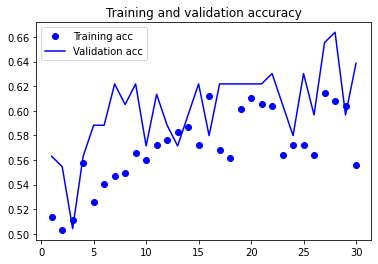

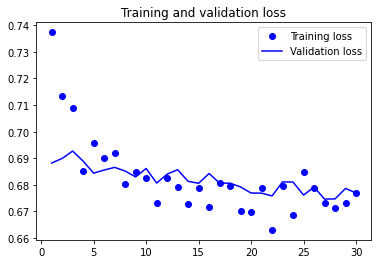

In [27]:
acc = history.history['acc']
print("keys", history.history)
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
# Using the testing generator to evaluate the model after training

test_generator = DCMDataFrameIterator(dataframe=test_set,
                             x_col='paths',
                             y_col='label',   
                             image_data_generator=test_datagen,
                             **test_consts)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))


Found 150 validated image filenames belonging to 2 classes.
150/150 [==============================] - 1s 7ms/step - loss: 0.6493 - acc: 0.6600


(1, 224, 224, 1)
(1,)


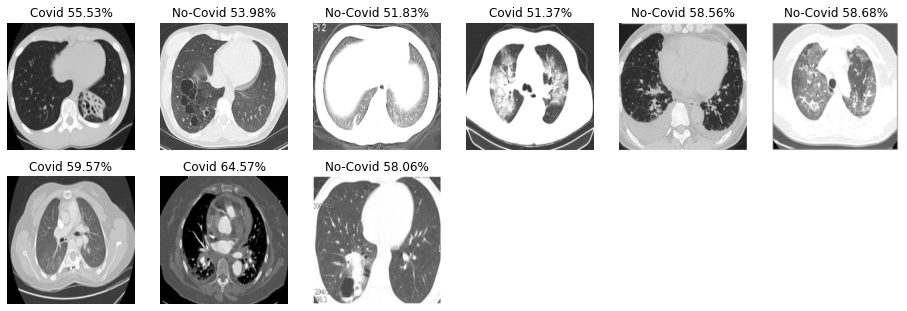

In [38]:
# show random results
import matplotlib.pyplot as plt

x, y = test_generator.next()

print(x.shape)
print(y.shape)
i = 0
plt.figure(figsize=(16, 8))
for i in range(9):    
    prediction = model.predict(np.expand_dims(x[0], axis=0))[0]
    
    plt.subplot(3, 6, i+1)
    if prediction[0] > prediction[1]:
        plt.title('Covid %.2f%%' % (prediction[0]*100))
    else:
        plt.title('No-Covid %.2f%%' % (prediction[1]*100))
    
    plt.axis('off')
    plt.imshow(x[0].squeeze(axis=2), cmap='gray', vmin=0, vmax=255)
    i += 1
    x, y = test_generator.next()
   
 